# Hello, Numerai

Hello and welcome to the Numerai Data Science Tournament!

In this notebook we will
1. Download and explore the dataset
2. Train our first machine learning model
3. Upload our model to start making live submissions

In [1]:
# Install dependencies
!pip install -q numerapi pandas matplotlib lightgbm cloudpickle pyarrow

# Inline plots
%matplotlib inline

## 1. Dataset  

At a high level, the Numerai dataset is a tabular dataset that describes the stock market over time. 

Each row represents a stock at a specific point in time, where `id` is the stock id and the `era` is the date. The `features` describe the attributes of the stock (eg. P/E ratio) known on the date and the `target` is a measure of future returns relative to the date.

The unique thing about Numerai's dataset is that it is obfuscated, which means that the underlying stock ids, feature names, and target definitions are anonymized. This makes it so that we can give this data out for free and so that it can be modeled without any financial domain knowledge (or bias).

Let's download the historical training data and take a closer look.

In [2]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()

# Print all files available for download in the latest v4.1 dataset
[f for f in napi.list_datasets() if f.startswith("v4.1")]

['v4.1/features.json',
 'v4.1/live.parquet',
 'v4.1/live_example_preds.csv',
 'v4.1/live_example_preds.parquet',
 'v4.1/live_int8.parquet',
 'v4.1/meta_model.parquet',
 'v4.1/train.parquet',
 'v4.1/train_int8.parquet',
 'v4.1/validation.parquet',
 'v4.1/validation_example_preds.csv',
 'v4.1/validation_example_preds.parquet',
 'v4.1/validation_int8.parquet']

In [3]:
import pandas as pd
import json

# Download the training data and feature metadata
# This may take a few minutes 🍵
napi.download_dataset("v4.1/train.parquet");
napi.download_dataset("v4.1/features.json");

# Load the training data but only the "small" subset of features to save time and memory
# In practice you will want to use all the features to maximize your model's performance
feature_metadata = json.load(open("v4.1/features.json")) 
feature_cols = feature_metadata["feature_sets"]["small"]
training_data = pd.read_parquet("v4.1/train.parquet", columns= ["era"] + feature_cols + ["target"]) 

# Print the training data
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 5)
training_data

2023-07-27 15:52:50,528 INFO numerapi.utils: target file already exists
2023-07-27 15:52:50,528 INFO numerapi.utils: download complete
2023-07-27 15:52:51,215 INFO numerapi.utils: target file already exists
2023-07-27 15:52:51,216 INFO numerapi.utils: download complete


,era,feature_bijou_penetrant_syringa,...,feature_unventilated_sollar_bason,target
id,,,,,
n003bba8a98662e4,0001,0.00,...,0.00,0.25
n003bee128c2fcfc,0001,0.50,...,0.25,0.75
n0048ac83aff7194,0001,0.25,...,1.00,0.25
n00691bec80d3e02,0001,0.75,...,0.75,0.75
n00b8720a2fdc4f2,0001,0.00,...,0.00,0.50
...,...,...,...,...,...
nffcc1dbdf2212e6,0574,1.00,...,1.00,0.75
nffd71b7f6a128df,0574,0.75,...,0.50,0.25
nffde3b371d67394,0574,0.75,...,1.00,0.25


As mentioned above, each `era` corresponds to a different date. The number of rows per `era` represents the number of stocks in Numerai's investable universe at that point in time.

Instead of thinking about each row as an example, it is helpful to think about each group of rows within the same `era` as an example. You will notice that throughout this notebook and other examples, we often talk about things "per era".

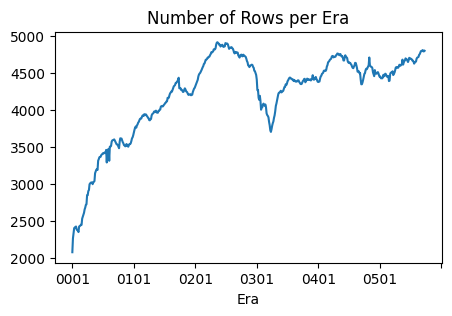

In [4]:
# Plot the number of rows per era
training_data.groupby("era").size().plot(title="Number of Rows per Era", figsize=(5, 3), xlabel="Era");

As mentioned above, the `features` are quantitative attributes of each stock, ranging from fundamentals like P/E ratio, to technical signals like RSI, to market data like short interest, to secondary data like analyst ratings, and much more. 

The underlying definition of each `feature` is not important, just know that Numerai has included these features in the dataset because we know believe they are predictive of the `target`.  

The `feature` values are regularized into 5 equal bins between 0 and 1 per era. This heavy regularization is to avoid overfitting as the underlying financial data is extremely noisy.

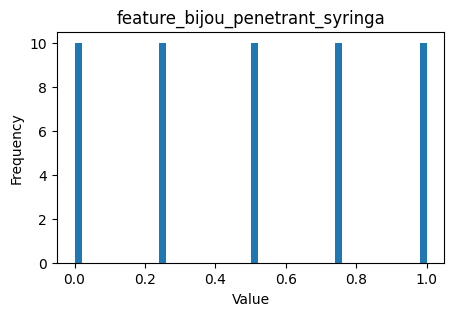

In [5]:
# Plot density histogram of the first feature 
training_data[feature_cols[0]].plot(kind="hist", title=feature_cols[0], figsize=(5, 3), xlabel="Value", density=True, bins=50);

As mentioned above, the `target` is a measure of stock market returns. And your task is to predict the `target` value. In other words, your task is to predict stock market returns.

The actual definition of the `target` is a bit more complex than just raw stock market returns. Given our hedge fund is market/country/sector and factor neutral, you can basically interpret the target as "stock-specific" returns that are not "explained" by broader trends in the market/country/sector or well known "factors". In other words: what we are after is "alpha".

The `target` value has also been regularized but into 5 unequal bins. The distribution of target values roughly map to the distribution of stock-specific returns across the stock market. 

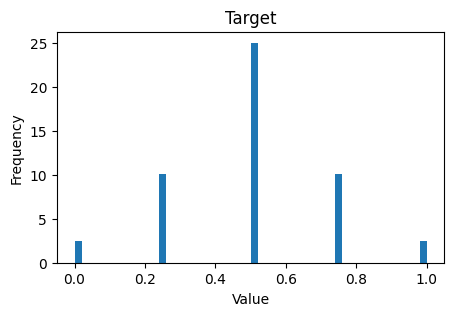

In [6]:
# Plot density histogram of the target
training_data["target"].plot(kind="hist", title="Target", figsize=(5, 3), xlabel="Value", density=True, bins=50);

## 2. Modeling
Now that we have explored the basics of the dataset, let's train our first model and evaluatae its performance.

Here we will be using LGBMRegressor, which is a popular choice amongst tournament participants, but you are free to use any tool or framework of your choice.

While you are waiting for the model to train, you can learn more about why tree based models work so well on tabular datasets from our Chief Scientist MDO: https://www.youtube.com/watch?v=w8Y7hY05z7k

In [7]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html 
import lightgbm as lgb

try: 
  # Load trained model if it exists
  model = lgb.Booster(model_file='small_lgb.model');
except lgb.basic.LightGBMError:
  # Otherwise train and save the model
  # This may take a few minutes 🍵
  model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=2 ** 5,
    colsample_bytree=0.1
  )
  model.fit(
    training_data[feature_cols],
    training_data["target"]
  );
  # Save model to disk
  model.booster_.save_model("small_lgb.model");

Now let's make some out-of-sample predictions on the validation dataset to evaluate our model's performance.

In [8]:
# Download validation data 
# This may take a few minutes 🍵
napi.download_dataset("v4.1/validation.parquet");

# Load the validation data but only the "small" subset of features
validation_data = pd.read_parquet("v4.1/validation.parquet", columns=["era", "data_type"] + feature_cols + ["target"]) 

# Filter for data_type == "validation"
validation_data = validation_data[validation_data["data_type"] == "validation"]
del validation_data["data_type"]

# Generate predictions against the out of sample validation features
# This may take a few minutes 🍵
validation_data["prediction"] = model.predict(validation_data[feature_cols])
validation_data[["era", "prediction", "target"]]

2023-07-27 15:52:56,153 INFO numerapi.utils: target file already exists
2023-07-27 15:52:56,154 INFO numerapi.utils: download complete


The primary scoring metric in Numerai is called `numerai_corr` or just `corr`, which is a Numerai specific variant of the Pearson Correlation Coefficient. This scoring metric is designed to "align incentives" between model scoring and hedge fund performance. In other words, a model with a good `CORR` should help the hedge fund make good returns.

On the Numerai website you will see it referred to as `CORR20V2`, where the `20` denotes that we are using the "20 day" version of the target and "v2" denotes that we are using the 2nd version of the scoring function. But don't worry too much about all of this for now, we will learn more about targets in a future tutorial.

In [ ]:
from scipy import stats
import numpy as np

# Numerai's primary scoring metric
def numerai_corr(preds, target):
    # rank (keeping ties) then gaussianize predictions to standardize prediction distributions
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # center targets around 0
    centered_target = target - target.mean()
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

As mentioned above, it is important for us to score each historical `era` independantly. So when evaluating the performance of our model, we should be looking at the "per era" `corr`.

One thing you may notice here is how low the scores are (in the range of +/- 5% correlation). This is very normal in the domain of quantitative finance and is part of the reason why we say Numerai is the "hardest data science tournament" in the world.

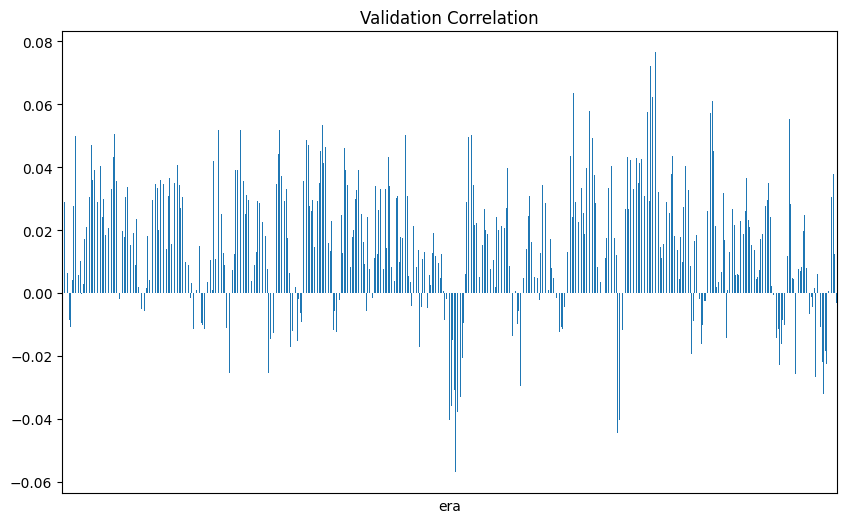

In [ ]:
# Compute the per-era correlation between our predictions and the target values
per_era_corr = validation_data.groupby("era").apply(lambda x: numerai_corr(x["prediction"], x["target"]))

# Plot the per-era correlation
per_era_corr.plot(kind="bar", title="Validation Correlation", figsize=(10, 6), xticks=[]);

Instead of looking at the the raw `corr` scores for each era, it is helpful to look at the cumulative `corr`. 

If you are familiar with "backtesting" in quant finance where people simulate the historical performance of their investment strategies, you can roughly think of this plot as a backtest of your model performance over the historical validation period.

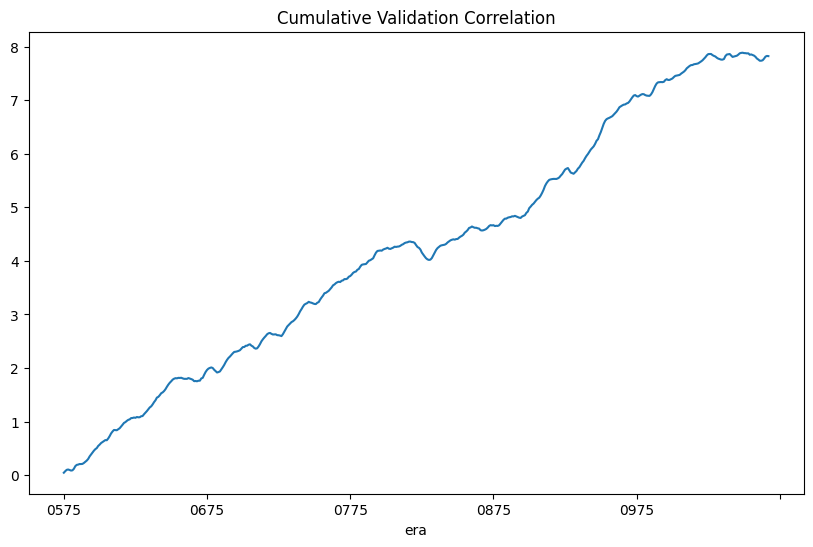

In [ ]:
# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(kind="line", title="Cumulative Validation Correlation", figsize=(10, 6));

To evaluate the performance of our model, it is also helpful to compute some summary metrics over the entire validation period.

`Mean` of correlations is the primary measure of your model's performance. An mean correlation above 0.02 is considered good.

`Sharpe` is a measure of your model's consistency, a concept borrowed from finance where it usually refers to risk adjusted returns of an investment strategy. In Numerai, we compute sharpe as the average correlation divided by the standard deviation of correlations. A Sharpe above 1 is considered good. 

`Max drawdown` is a measure of your model's risk, another concept borrowed from finance where it usually refers to the maximum financial loss suffered by an investment strategy. In Numerai, we compute max drawdown as the maximum peak to trough drop in cumulative validation correlation. A max drawdown below 0.1 in magnitude is considered good.

In [ ]:
# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
max_drawdown = -(per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

pd.DataFrame({
    "Mean": corr_mean,
    "Standard Deviation": corr_std,
    "Sharpe Ratio": corr_sharpe,
    "Max Drawdown": max_drawdown
}, index=["Value"]).T

,Value
Mean,0.015869
Standard Deviation,0.021336
Sharpe Ratio,0.743799
Max Drawdown,-0.342537


These performance metrics above is not great but it is good enough for us to get started. Don't worry, we will be learning how to improve our model performance in the next tutorials.

## 3. Submissions 
Unlike Kaggle competitions that evalute model performance based on a hold-out test set, Numerai evaluates performance based on the <ins>live dataset</ins> which represents the live stock market.

Every Tuesday-Saturday, a new `live era` of features is released which represents the current state of the stock market. Your task is to use these `live features` to make `live predictions` on the unknown target value, which represents stock market returns 20 days into the future. 

The `live performance` of your models are what you can stake the NMR cryptocurrency on to earn rewards. More on staking later, for now let us focus on how to make a submission.

In [ ]:
# Check the current round number. New rounds start every Tuesday-Saturday.
current_round_number = napi.get_current_round()

# Download latest live features for the current round number 
napi.download_dataset("v4.1/live.parquet", f"v4.1/live_{current_round_number}.parquet")

# Load live features
live_features = pd.read_parquet(f"v4.1/live_{current_round_number}.parquet", columns=feature_cols)

# Generate live predictions with our trained model
live_predictions = model.predict(live_features[feature_cols])

# Format submission
submission = pd.Series(live_predictions, index=live_features.index).to_frame("prediction")
submission

2023-07-27 15:48:47,850 INFO numerapi.utils: target file already exists
2023-07-27 15:48:47,851 INFO numerapi.utils: download complete


,prediction
id,
n001c8fa54b1d611,0.497211
n001f0b161cc90fc,0.491729
n00275a82a0739bd,0.504658
n00314637402fd75,0.497841
n003afe9ec01bdd4,0.506086
...,...
nffa71f514e451d4,0.519704
nffd0955c3c413a9,0.502382
nffd760be1277881,0.511483


To participate in the tournament, we must submit live predictions every Tuesday-Saturday. 

A free and simple way to automate this daily submission process is to upload your model to Numerai and let Numerai take care of running it daily to generate live predictions.

How it works:
- Define your prediction pipeline as a function
- Serialize your function and your trained model using the `cloudpickle` library
- Numerai runs your model to generate and submit live predictions every day

Read more about Model Uploads and other self-hosted automation options in our [docs](https://docs.numer.ai/numerai-tournament/submissions#automation).


In [ ]:
# Define your prediction pipeline as a function that takes an era of features as input and outputs your predictions for that era
def predict(live_features: pd.DataFrame) -> pd.DataFrame:
    live_predictions = model.predict(live_features[feature_cols])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")

In [ ]:
# Quick test
predict(live_features)

,prediction
id,
n001c8fa54b1d611,0.497211
n001f0b161cc90fc,0.491729
n00275a82a0739bd,0.504658
n00314637402fd75,0.497841
n003afe9ec01bdd4,0.506086
...,...
nffa71f514e451d4,0.519704
nffd0955c3c413a9,0.502382
nffd760be1277881,0.511483


In [ ]:
# Use the cloudpickle library to serialize your function
import cloudpickle
p = cloudpickle.dumps(predict)
with open("predict.pkl", "wb") as f:
    f.write(p)

In [ ]:
# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('predict.pkl')
except:
    pass

That's it! You now have a pickle file that is ready for upload.

Head back to the [Hello Numerai Tutorial](https://numer.ai/tutorial/hello-numerai) to upload your model! 